In [1]:
import functools
import operator
from IPython.display import Image, display
from typing import Annotated, Optional, Any, Sequence, Union
from langchain_core.tools import tool
from typing_extensions import TypedDict
from langchain.agents import (
    AgentExecutor,
    create_openai_tools_agent,
)
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
)
from langgraph.graph import END, START, StateGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langgraph.checkpoint.sqlite import SqliteSaver

In [2]:
class ComparisonVariables(BaseModel):
    brand: str = Field(description="brand name of the product", max_length=20)
    industry: str = Field(description="industry of the product")
    year: int = Field(description="Year of the product information", ge=2000)


class ColorTrendVariables(BaseModel):
    brand: str = Field(description="brand name of the product", max_length=20)
    start_year: int = Field(description="Starting year of the product information")
    end_year: int = Field(description="Ending year of the product information")


class PrechatVariables(BaseModel):
    full_name: str = Field(description="Full name of the user", max_length=25)
    mobile_number: str = Field(description="Mobile Number of the user", max_length=10)
    email_id: str = Field(description="mail ID of the user", max_length=40)

In [3]:
@tool
def Identity(query):
    """This is the identity function return whatever user pass in query."""
    return query

In [4]:
llm = ChatOpenAI()

In [5]:
def create_agent(llm, tools: list, system_prompt):
    agent = create_openai_tools_agent(llm, tools, system_prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [6]:
prompt_template_comparison = """
    You are responsible for handling queries that involve comparisons between the color family frequency of specific automobile brands and the overall auto industry for specified years. Your goal is to provide accurate comparisons based on the given criteria and follow the instructions precisely.

    Don't answer to question focus only on your task your task isn't to answer questions.

    Key Tasks:
    Feature Extraction Focus:
    Extract details about the automobile brand and the period specified in the query.
    Ensure only the information explicitly mentioned in the query is extracted.
    
    Example Queries:

    "Can I see a comparison of the color family frequency for Audi and the auto industry in 2023?"
    "What does the color family frequency look like for BMW versus the auto industry over the last three years?"
    "How does the color family frequency for Toyota compare to the rest of the auto industry in 2022?"
    Output Format:

    Follow the provided format instructions.
    Once all features are extracted and formatted according to the instructions, your task is complete.

    Final Step:
    Output Format:
    {format_instructions}
    Always conclude your response with "FINISH" once the features are correctly extracted and formatted.
"""
comparison_parser = JsonOutputParser(pydantic_object=ComparisonVariables)

In [7]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            prompt_template_comparison,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ],
).partial(format_instructions=comparison_parser.get_format_instructions())

In [8]:
comparison_agent = create_agent(llm=llm, tools=[Identity], system_prompt=prompt)

In [9]:
prompt_color_trend = """You are responsible for handling queries that focus on the color trends and usage of specific automobile brands over various periods. Your main task is to provide detailed analysis and summaries of color families used by these brands. Here are your key tasks:
    
    Don't answer to question focus only on your task your task isn't to answer questions.

    Feature Extraction Focus:
    Extract details about the automobile brand and the period specified in the query.
    Ensure only the information explicitly mentioned in the query is extracted.

    Features to Extract:
    Brand: The specific brand mentioned in the query.
    Period: The specific period mentioned in the query (e.g., "last five years," "past decade").
    Even industry is mentioned in query do not extract it.

    Example Queries and Extracted Features:

    Extracted Features:
    Brand: Audi
    Start year: 2019
    End year: 2024

    Query: "Can you tell me the color trends for Toyota and audi vehicles over the past decade?"

    Extracted Features:
    Brand: [Toyota,audi]
    Start year: 2015
    End year: 2024

    Output Format:
    {format_instructions}
    Once the features are extracted and formatted, your task is complete return features with FINISH.
"""

colour_trend_parser = JsonOutputParser(pydantic_object=ColorTrendVariables)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            prompt_color_trend,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
).partial(format_instructions=colour_trend_parser.get_format_instructions())

colortrend_agent = create_agent(llm, [Identity], prompt)

In [10]:
greeting_prompt = """
You are responsible for handling the initial interaction with users by providing a friendly and welcoming greeting. Your primary role is to acknowledge the user's presence, make them feel comfortable, and briefly inform them of the services available. Once you have greeted the user and provided the necessary information, your task ends. Here are your key tasks:

Greeting:

Start the conversation with a warm and friendly greeting.
Acknowledge the user's presence and make them feel welcome.

Introduction to Services:
Briefly inform the user about the available services, such as extracting information related to automobile brands, color trends, industry comparisons, and more.
Let the user know that you can route their query to the appropriate agent based on their needs.

Example Interactions:
"Hello! Welcome! I'm here to help you with any questions you have about color trends, brand comparisons, and more. Just let me know what you're looking for, and I'll guide you to the right place."
"Hi there! It's great to see you. I'm here to assist you with queries related to brands, color trends, and industry comparisons. How can I help you today?"

End of Task:
Once you have greeted the user and provided an overview of the services, your task is complete. Do not perform any further actions.

Output Format:
Provide the greeting and service introduction in a clear and concise manner.
"""

prechat_prompt = """
You are responsible for collecting essential personal information from the user before they engage with other agents in the workflow. Your primary role is to politely request and gather the user's name, mobile number, email address, and any other necessary details. Once all required information is collected, your task ends, and the conversation is passed on to the next appropriate agent. Here are your key tasks:

Greeting and Request for Information:

Start with a polite and professional greeting.
Clearly explain that you need to collect some basic information before proceeding.
Request the user's full name, mobile number, and email address. if user has forgot to provide any information, ask for it again and FINISH.

Information Collection:
Ensure that you gather the following details:
{format_instructions}


End of Task:
After successfully collecting and confirming the user's information, your task is complete. your task is completed and respond with FINISH.
"""

feedback_prompt = """
You are an expert for taking feedback from user. 
You have to ask user for feedback in a clear and concise manner.
ask them questions one by one.

Did our conversation meet your expectations? (Yes/No)
If you faced any issues or encountered any problems, please describe them here:
Do you have any suggestions for improvements or additional features you'd like to see?
Your feedback is valuable and will help us enhance our service. Thank you!
"""

In [11]:
greeting_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            greeting_prompt,
        ),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ],
)
greeting_agent = create_agent(llm, [Identity], greeting_prompt_template)

prechat_parser = JsonOutputParser(pydantic_object=PrechatVariables)

prechat_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            prechat_prompt,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ],
).partial(format_instructions=prechat_parser.get_format_instructions())

prechat_agent = create_agent(llm, [Identity], prechat_prompt_template)

feedback_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            prechat_prompt,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ],
)

feedback_agent = create_agent(llm, [Identity], feedback_prompt_template)

In [12]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [13]:
members = [
    "comparison_agent",
    "colortrend_agent",
    "greeting_agent",
    "prechat_agent",
    "feedback_agent",
]
system_prompt = """
You are tasked with routing user queries to the appropriate agent based on their content. 
agents : {members}
There are two groups of questions: Group 1 focuses on comparing the color family frequency of specific automobile brands with the overall auto industry for specified years. 
Group 2 focuses on the color trends and usage of specific automobile brands over various periods. 
Use the following guidelines to determine which agent to choose:

Greeting Agent:

The Greeting Agent will greet the user and provide an overview of available services.
After the greeting is complete, the user query should be passed back for further routing to the appropriate agent based on content.

Prechat Agent:

the Prechat Agent will talk with User if user haven't provided any information of their name, mobile number, email id 
than prechat agent will tell the user to first provide the information and than user's query will be processed further.

Comparision Agent:

Choose this agent if the question involves a comparison between a specific automobile brand and the overall auto industry for one or more specified years.
Look for keywords like "compare," "comparison," "year(s)," "industry," and specific brand names (e.g., Audi, BMW, Toyota).

Colortrend Agent:

Choose this agent if the question involves analyzing or listing the color families or trends of specific automobile brands over any given period.
Look for keywords like "color trends," "color families," "usage," "period," and specific brand names (e.g., Audi, BMW, Toyota).

Feedback Agent:
Choose this Agent when the user's task is done and get a feedback from user about the conversation that user didn't faced any issue in the conversation.

Instructions for Differentiation:

Identify whether the query is about a comparison with the auto industry  or a focus on a specific brand's historical color usage .
Determine if the query involves specific years for a comparison  or a broader analysis of color trends over time. or query is just normal converstion than you should move to gretting agent or prechat agent according to user input.

Once you get FINISH from agents then finish execution.
"""

options = ["FINISH"] + members

function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above , who should act next?"
            "Or should we FINISH? Select one of : {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI()
# llm=ChatGroq()

supervisor_chain = (
    prompt
    | llm.bind_functions(
        functions=[function_def],
        function_call="route",
    )
    | JsonOutputFunctionsParser()
)

In [14]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

    next: str

In [15]:
comparison_node = functools.partial(agent_node, agent=comparison_agent, name="comparison_agent")
colortrend_node = functools.partial(agent_node, agent=colortrend_agent, name="colortrend_agent")
greeting_node = functools.partial(agent_node,agent=greeting_agent,name="greeting_agent")
prechat_node = functools.partial(agent_node,agent=prechat_agent,name="prechat_agent")
feedback_node = functools.partial(agent_node,agent=feedback_agent,name="feedback_agent")

In [20]:
workflow = StateGraph(AgentState)
workflow.add_node("comparison_agent", comparison_node)
workflow.add_node("colortrend_agent", colortrend_node)
workflow.add_node("greeting_agent", greeting_node)
workflow.add_node("prechat_agent", prechat_node)
workflow.add_node("feedback_agent", feedback_node)
workflow.add_node("supervisor", supervisor_chain)

for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges(
    "supervisor",
    lambda x: (
        # "FINISH" if any("FINISH" in msg.content for msg in x["messages"]) else x["next"]
        x["next"]
    ),
    conditional_map,
)
workflow.add_edge(START, "supervisor")
memory = SqliteSaver.from_conn_string(":memory:")
graph = workflow.compile(checkpointer=memory)
# print(conditional_map)

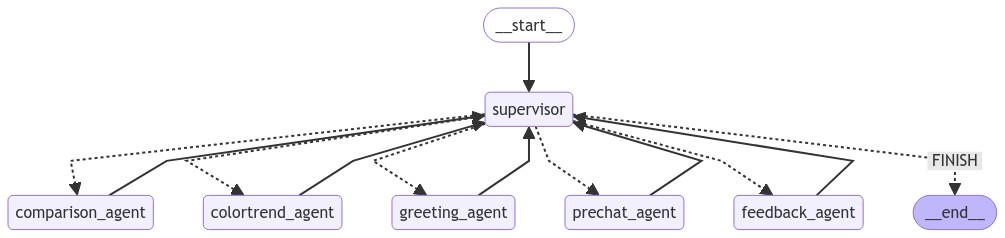

In [21]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [18]:
# conversation_state = {}
config = {"configurable": {"thread_id": "1"}}

for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="My mail is abc@mail.com",
            )
        ],
        "recursion_limit": 5,
    },
    config=config,
):
    print(s)
    print("---")

{'supervisor': {'next': 'prechat_agent'}}
---
{'prechat_agent': {'messages': [HumanMessage(content="Hello! Before we proceed, I need to collect some basic information from you. Could you please provide me with your full name, mobile number, and email address? Let's start with your full name.", name='prechat_agent')]}}
---
{'supervisor': {'next': 'prechat_agent'}}
---
{'prechat_agent': {'messages': [HumanMessage(content="I'm sorry, but I need your full name to proceed. Can you please provide it?", name='prechat_agent')]}}
---
{'supervisor': {'next': 'prechat_agent'}}
---
{'prechat_agent': {'messages': [HumanMessage(content='{"properties": {"full_name": {"description": "Full name of the user", "maxLength": 25, "title": "Full Name", "type": "string"}, "mobile_number": {"description": "Mobile Number of the user", "maxLength": 10, "title": "Mobile Number", "type": "string"}, "email_id": {"description": "mail ID of the user", "maxLength": 40, "title": "Email Id", "type": "string"}}, "require

In [22]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for s in graph.stream({"messages": [HumanMessage(content=user_input)]}, config):
        if "__end__" not in s:
            print(s)
            print("----")

{'supervisor': {'next': 'greeting_agent'}}
----
{'greeting_agent': {'messages': [HumanMessage(content="Hello! Welcome! I'm here to help you with any questions you have about color trends, brand comparisons, and more. Just let me know what you're looking for, and I'll guide you to the right place.", name='greeting_agent')]}}
----
{'supervisor': {'next': 'prechat_agent'}}
----
{'prechat_agent': {'messages': [HumanMessage(content='I need to collect some basic information from you before we proceed. Could you please provide me with your full name, mobile number, and email address?', name='prechat_agent')]}}
----
{'supervisor': {'next': 'prechat_agent'}}
----
{'prechat_agent': {'messages': [HumanMessage(content='Thank you for providing the necessary information. We have successfully collected your details. Your information is secure with us. Is there anything else you would like assistance with? If not, feel free to ask anytime. Have a great day! \n\nFINISH', name='prechat_agent')]}}
----
{